# Import

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import os
from collections import Counter
from typing import List

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from matplotlib.path import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from utils import load_image
from cnn import ClassificationModel
from config import *

# Data

In [3]:
data_path = os.path.join('..', DSET_BASE_DIR)

In [4]:
fnames = [fname for fname in os.listdir(data_path) if '-' in fname]
print(fnames)

['muffin-4.jpeg', 'muffin-8.jpeg', 'muffin-7.jpeg', 'chihuahua-8.jpg', 'muffin-3.jpeg', 'chihuahua-6.jpg', 'chihuahua-1.jpg', 'chihuahua-4.jpg', 'muffin-6.jpeg', 'chihuahua-2.jpg', 'muffin-5.jpeg', 'chihuahua-7.jpg', 'muffin-2.jpeg', 'chihuahua-5.jpg', 'muffin-1.jpeg', 'chihuahua-3.jpg']


In [5]:
images = []
labels = []
dset_ids = []
for img_fname in tqdm(fnames):
    img_path = os.path.join(data_path, img_fname)
    img = load_image(img_path, img_size=IMG_SIZE)
    images.append(img)
    labels.append(img_fname.split('-')[0])


  0%|          | 0/16 [00:00<?, ?it/s]

Counter({'muffin': 8, 'chihuahua': 8})


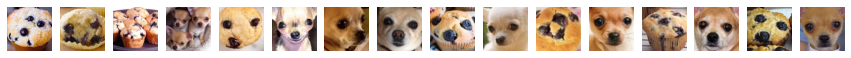

In [6]:
c = Counter(labels)
print(c)

plt.figure(figsize=(15,5))
for i, img in enumerate(images, start=1):
    plt.subplot(1, len(images), i)
    plt.axis('off')
    plt.imshow(img);

## Dataset

In [7]:
class FunDataset(Dataset):

    def __init__(self, 
                 images: List[Image.Image], 
                 labels: List[str], 
                 n_classes: int = 2,
                 img_size: int = 224,
                 augmentation: A.Compose = None, 
                 preprocessing: A.Compose = None,):

        self.images = images
        self.labels = labels
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.n_classes = n_classes
        self.img_size = img_size


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):  
        
        image = self.images[idx]
        label = self.labels[idx]
        label = CLASSES_MAP[label]
        
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

        if self.preprocessing:
            image = self.preprocessing(image)

        return image, label

In [8]:
test_dataset = FunDataset(images,labels)

In [9]:
%%time
test_dataset.__getitem__(0);

CPU times: user 0 ns, sys: 12 µs, total: 12 µs
Wall time: 17.2 µs


(<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD5D9DACA90>, 1)

# LightningDataModule

In [10]:
class FunDataModule(pl.LightningDataModule):
    def __init__(self, 
                 images: List[Image.Image], 
                 labels: List[str], 
                 n_classes: int = 2,
                 img_size: int = 224,
                 batch_size: int = 16,
                 test_size: float = 0.2,
                 encoder_prepr_fn = None,
                 aug=False,
                 prepr=False,
                 ):
        
        super().__init__()
        
        self.images = images
        self.labels = labels
        self.n_classes = n_classes
        self.train_aug = self.get_training_augmentation() if aug else None
        self.valid_aug = self.get_validation_augmentation() if aug else None
        self.preprocessing = encoder_prepr_fn if prepr else None

        self.save_hyperparameters('batch_size', 'img_size',
                                  'test_size', 'aug')


    def setup(self, stage: List[str] = None):

        train_ids, valid_ids = train_test_split(np.arange(len(self.images)), 
                                                test_size = self.hparams.test_size, 
                                                random_state=7,
                                                stratify=self.labels)
                                                

        print(train_ids.shape[0], 'train images')
        print(valid_ids.shape[0], 'validation images')
        
        self.train_ds = FunDataset(
            [self.images[idx] for idx in train_ids],
            [self.labels[idx] for idx in train_ids],
            self.n_classes,
            self.hparams.img_size,
            augmentation=self.train_aug,
            preprocessing=self.preprocessing
        )

        self.valid_ds = FunDataset(
            [self.images[idx] for idx in valid_ids],
            [self.labels[idx] for idx in valid_ids],
            self.n_classes,
            self.hparams.img_size,
            augmentation=self.train_aug,
            preprocessing=self.preprocessing
        )


    def train_dataloader(self):
        return DataLoader(self.train_ds,
                          batch_size=self.hparams.batch_size,
                          pin_memory=True,
                          drop_last=True,
                          shuffle=True,     
                          num_workers=4,
                          )


    def val_dataloader(self):
        return DataLoader(self.valid_ds,
                          batch_size=self.hparams.batch_size,
                          pin_memory=True,
                          drop_last=False,
                          shuffle=False,     
                          num_workers=4,
                          )


    def test_dataloader(self):
        return None


    def get_training_augmentation(self):
        pass


    def get_validation_augmentation(self):
        pass


    def get_test_augmentation(self):
        pass


    def to_tensor(self, x, **kwargs):
        return torch.FloatTensor(x).permute(2, 0, 1)


    def get_preprocessing(self, preprocessing_fn):
        
        _transform = [
            A.Lambda(image=preprocessing_fn),
            A.Lambda(image=self.to_tensor, mask=self.to_tensor)
        ]
        return A.Compose(_transform)


In [11]:
%%time
crack_segm_data = FunDataModule(images,
                                  labels,
                                  dset_ids,
                                  batch_size=BATCH_SIZE,
                                  img_size=IMG_SIZE, 
                                  aug=True
                                  )

crack_segm_data.setup()

12 train images
4 validation images
CPU times: user 7.33 ms, sys: 2.02 ms, total: 9.35 ms
Wall time: 6.39 ms


# Train

In [12]:
model = ClassificationModel(model_name=BACKBONE,
                          lr=LR,
                          n_classes=NCLASSES
                          )

Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnet18-118f1556.pth" to /root/.cache/torch/hub/checkpoints/semi_weakly_supervised_resnet18-118f1556.pth
/usr/local/lib/python3.8/dist-packages/deprecate/deprecation.py:115: FutureWarning: The `F1` was deprecated since v0.7 in favor of `torchmetrics.classification.f_beta.F1Score`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


In [13]:
crack_segm_data = FunDataModule(images,
                                  labels,
                                  dset_ids,
                                  batch_size=BATCH_SIZE,
                                  img_size=IMG_SIZE, 
                                  aug=True,
                                  prepr=True,
                                  encoder_prepr_fn=model.preprocessing_fn
                                  )
# crack_segm_data.setup()

In [14]:
ckpt_path = '../models/chkpts/{epoch}-{val_f1:.2f}-{val_accuracy:.2f}-{val_loss:.4f}'
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", 
                                                   mode='min',
                                                   save_last=False,
                                                   filename=ckpt_path
)
trainer = pl.Trainer(precision=16, 
                     gpus=1,
                     callbacks=[checkpoint_callback],
                     max_epochs=5,
                     log_every_n_steps=6
                     )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model,
            datamodule=crack_segm_data
            )

12 train images
4 validation images


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | model      | ResNet            | 11.2 M
1 | sigmoid    | Sigmoid           | 0     
2 | loss_fn    | BCEWithLogitsLoss | 0     
3 | accuracy   | Accuracy          | 0     
4 | precision_ | Precision         | 0     
5 | recall     | Recall            | 0     
6 | f1         | F1                | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
22.354    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Test

In [16]:
path = trainer.checkpoint_callback.best_model_path
# path = 'lightning_logs/version_39/checkpoints/models/chkpts/epoch=4-val_f1=1.00-val_accuracy=1.00-val_loss=0.0457.ckpt'
loaded_model = ClassificationModel.load_from_checkpoint(path).to(DEVICE)

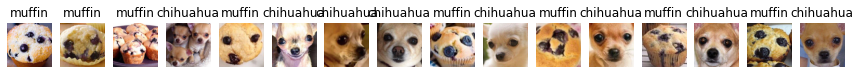

In [17]:
loaded_model.eval()

plt.figure(figsize=(15,5))
for i, img in enumerate(images, start=1):
    plt.subplot(1, len(images), i)
    plt.imshow(img)
    
    img = loaded_model.preprocessing_fn(img).unsqueeze(0).to(DEVICE)
    pred = torch.sigmoid(loaded_model(img))
    pred = pred.detach().cpu().tolist()[0][0]
    label = CLASSES_BY_IDX[int(pred>0.5)]
    plt.axis('off')
    
    plt.title(str(label))
    

# Save model

In [18]:
!mv {trainer.checkpoint_callback.best_model_path} ../models/model.ckpt
